## $\text {Import libraries}$

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.datasets import cifar10
from torchvision import transforms
from torch.optim import SGD, AdamW
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
custom = {"axes.edgecolor": "black", "grid.linestyle": "dashed", "grid.color": "gray"}
sns.set_style("darkgrid", rc = custom)

## $\text {Importing data}$

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


## $\text {Let`s normilize values of every pixel since it will be better for our model}$

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
def print_img(img, label):
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)

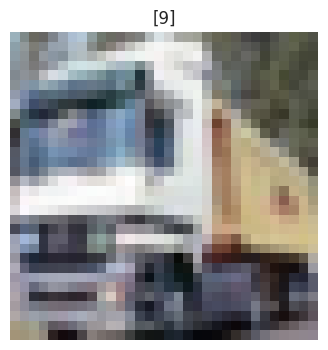

In [6]:
print_img(X_train[1], y_train[1])

## $\text {Making class Dataset}$

In [7]:
class CIFAR10(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.transpose(0, 3, 1, 2)).type(torch.float32)
        self.y = torch.from_numpy(y)
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # Нормализуем среднее значение всех пикселей и их квадратичное отклонение
        ])

    def __getitem__(self, index):
        return self.preprocess(self.X[index]), self.y[index]

    def __len__(self):
        return len(self.X)

In [8]:
train_data = CIFAR10(X_train, y_train)
test_data = CIFAR10(X_test, y_test)

In [9]:
train_loader = DataLoader(train_data, 64, shuffle=True)
test_loader = DataLoader(test_data, 64)

### $\text{For our NN I`ll make ResidualBlock to simplify the code}$

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, is_identity=True):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.is_identity = is_identity
        self.ReLU = nn.ReLU()

        if not self.is_identity or in_channels != out_channels or self.stride != 1:
            self.identity_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                           stride=self.stride)
        else:
            self.identity_conv = None


        self.layer1 = nn.Sequential(
            nn.Conv2d(kernel_size=3, in_channels=self.in_channels,
                    out_channels=self.out_channels, stride=self.stride,
                    padding=1),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(kernel_size=3, in_channels=self.out_channels,
                    out_channels = self.out_channels, stride=1,
                    padding=1),
            nn.BatchNorm2d(self.out_channels)
        )

    def forward(self, X):
        out = self.layer1(X)
        # print(out.shape)
        out = self.layer2(out)
        # print(out.shape)
        residual = self.identity_conv(X) if self.identity_conv != None else X
        out = out + residual

        out = self.ReLU(out)

        return out


### $\text{Model structure}$

In [11]:
class ResNet34(nn.Module):     # nn.Module - функционал torch.nn
    def __init__(self, in_channels):
        super(ResNet34, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 64, 1),
            ResidualBlock(64, 64, 1),
            ResidualBlock(64, 64, 1)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128, 2, is_identity=False),
            ResidualBlock(128, 128, 1),
            ResidualBlock(128, 128, 1),
            ResidualBlock(128, 128, 1)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(128, 256, 2, is_identity=False),
            ResidualBlock(256, 256, 1),
            ResidualBlock(256, 256, 1),
            ResidualBlock(256, 256, 1),
            ResidualBlock(256, 256, 1),
            ResidualBlock(256, 256, 1)
        )
        self.layer5 = nn.Sequential(
            ResidualBlock(256, 512, 2, is_identity=False),
            ResidualBlock(512, 512, 1),
            ResidualBlock(512, 512, 1)
        )
        self.layer6 = nn.Sequential(
            nn.AvgPool2d(7)
        )
        self.layer7 = nn.Sequential(
            nn.Linear(512, 10)
        )


    def forward(self, X):
        X = self.layer1(X)
        X = self.layer2(X)
        X = self.layer3(X)
        X = self.layer4(X)
        X = self.layer5(X)
        X = self.layer6(X)
        # print(X, X.shape)
        X = X.flatten(start_dim=1)
        X = self.layer7(X)
        return X

In [12]:
# Это нужно для выбора устройства, на котором мы будем обучать. 'cuda' - видеокарта
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### $\text{Training process}$

In [13]:
epochs = 10
lr = 0.001

net = ResNet34(3).to(device=device)

In [14]:
optimizer = SGD(params = net.parameters(), weight_decay = 0.0001, momentum=0.9, lr=lr)
criterion = nn.CrossEntropyLoss()

In [15]:
net.train()

for epoch in range(epochs):
    epoch_loss = []
    for batch in tqdm(train_loader):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        out = net(X_batch.to(device=device))
        loss = criterion(out.cpu(), y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    print(np.mean(epoch_loss))

  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 782/782 [04:54<00:00,  2.65it/s]


1.3630774373288654


100%|██████████| 782/782 [05:02<00:00,  2.58it/s]


0.8147130246891086


100%|██████████| 782/782 [05:03<00:00,  2.58it/s]


0.5754992723693628


100%|██████████| 782/782 [05:03<00:00,  2.58it/s]


0.4311818760984084


100%|██████████| 782/782 [05:03<00:00,  2.58it/s]


0.31440300589708414


100%|██████████| 782/782 [05:03<00:00,  2.58it/s]


0.2234259001824938


100%|██████████| 782/782 [05:02<00:00,  2.58it/s]


0.14725706414998416


100%|██████████| 782/782 [05:03<00:00,  2.58it/s]


0.10484600291156289


100%|██████████| 782/782 [05:03<00:00,  2.58it/s]


0.07708448883088882


100%|██████████| 782/782 [05:03<00:00,  2.58it/s]

0.05226446607369272


## $\text{Inference}$

In [16]:
net.eval()

accuracies = []

for batch in test_loader:
    with torch.no_grad():
        out = net(batch[0].to(device))
    predictions = out.argmax(axis=-1)
    accuracies.append(accuracy_score(batch[1], predictions.cpu()))
print(f'Accuracy of model = {np.mean(accuracies)}')

Accuracy of model = 0.8067277070063694
